In [61]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [62]:
!pip install sklearn

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [64]:
start = datetime.datetime(2015,7,1)
end = datetime.datetime(2021,4,30)

In [65]:
df = web.DataReader("TDOC",'yahoo',start,end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-26,190.339996,180.529999,184.009995,190.059998,2922500,190.059998
2021-04-27,192.110001,188.000000,190.789993,189.949997,2170900,189.949997
2021-04-28,189.654999,185.399994,186.330002,186.309998,2959500,186.309998
2021-04-29,178.679993,167.809998,174.710007,170.860001,12156900,170.860001
2021-04-30,174.570007,167.869995,169.240005,172.350006,4084400,172.350006


In [66]:
#rolling mean / moving average - smooths out price data by creating a constantly updated average price - useful for cuttinr out noise in price chart and act as resistance

close_px = df['Adj Close']
mavg = close_px.rolling(window = 100).mean()
mavg


Date
2015-06-30         NaN
2015-07-01         NaN
2015-07-02         NaN
2015-07-06         NaN
2015-07-07         NaN
                ...   
2021-04-26    216.5185
2021-04-27    216.4661
2021-04-28    216.3789
2021-04-29    216.1154
2021-04-30    215.8023
Name: Adj Close, Length: 1470, dtype: float64

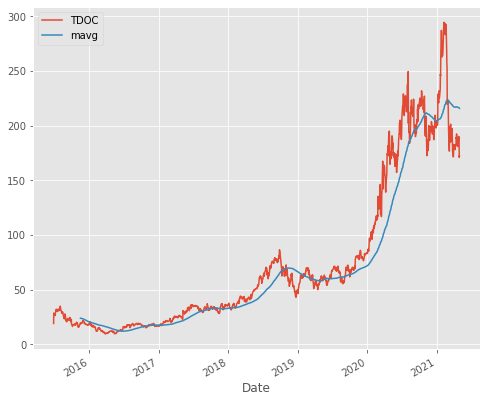

In [67]:
#plots moving average which shows the increasing or decreasing trend of stock price. Buy when stocks are experiencing downturn and sell when stocks are experiencing upturn
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
mpl.rc('figure',figsize=(8,7))
mpl.__version__

style.use('ggplot')

close_px.plot(label='TDOC')
mavg.plot(label='mavg')
plt.legend()

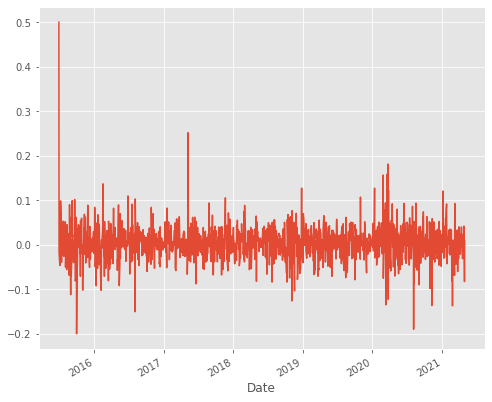

In [68]:
#Return deviation - to determine risk and return
#Expected return measures mean of investment returns
#calculated by multiplying weight of each asset by its expected return and adding values for each investment

#Ideal stock should return as high and stable as possible
#sharp drop observed in mid 2020

rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')


In [69]:
#analysing your competitors
dfcomp = web.DataReader(['TDOC','ISRG','GSK','SYK'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,TDOC,ISRG,GSK,SYK
Date,,,,
2021-04-26,190.059998,865.940002,37.779999,265.279999
2021-04-27,189.949997,861.380005,37.730000,265.029999
2021-04-28,186.309998,868.789978,37.700001,259.579987
2021-04-29,170.860001,863.219971,37.500000,263.429993
2021-04-30,172.350006,865.000000,37.340000,262.630005


In [70]:
#correlation analysis - does one competitor affect others
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr

Symbols,TDOC,ISRG,GSK,SYK
Symbols,,,,
TDOC,1.000000,0.243143,0.122209,0.137219
ISRG,0.243143,1.000000,0.391256,0.649841
GSK,0.122209,0.391256,1.000000,0.441285
SYK,0.137219,0.649841,0.441285,1.000000


Text(0, 0.5, 'Returns SYK')

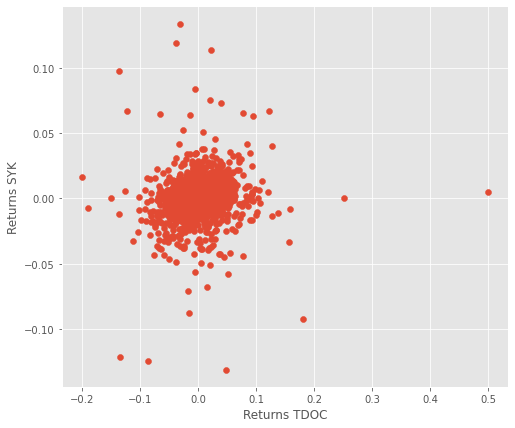

In [71]:
plt.scatter(retscomp.TDOC, retscomp.SYK)
plt.xlabel('Returns TDOC')
plt.ylabel('Returns SYK')

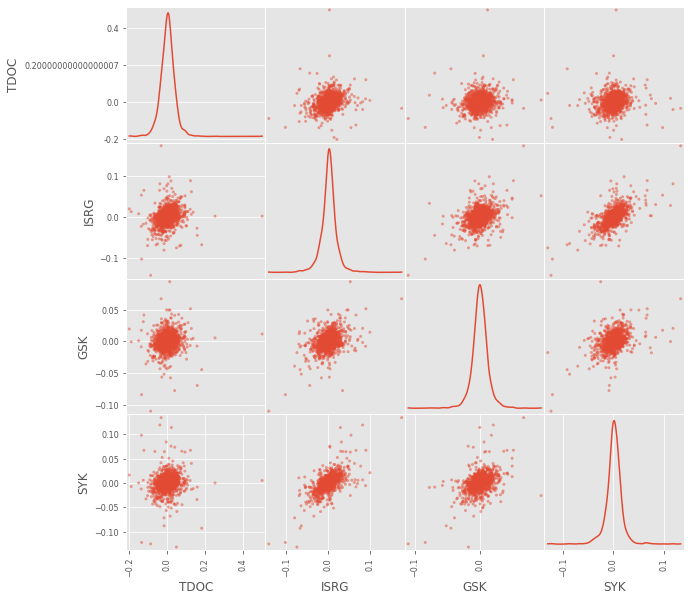

In [72]:
from pandas.plotting import scatter_matrix
pd.plotting.scatter_matrix(retscomp,diagonal ='kde', figsize=(10,10));

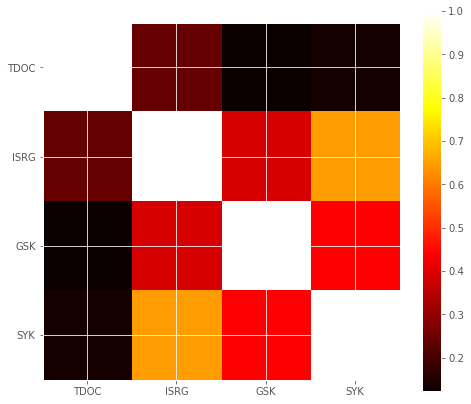

In [73]:
#heat maps - to visualize correlation ranges among competing stocks, lighter colour - more correlated
plt.imshow(corr, cmap='hot',interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns)
plt.yticks(range(len(corr)),corr.columns);

#does not show causality and show trend in technology industry rather than show how competing stocks affect each other 

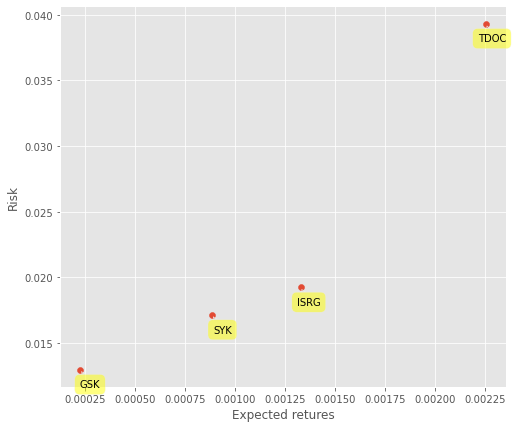

In [74]:
plt.scatter(retscomp.mean(),retscomp.std())
plt.xlabel('Expected retures')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(),retscomp.std()):
    plt.annotate(label, 
    xy = (x,y), xytext = (20, -20), 
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad = 0.5', fc = 'yellow', alpha = 0.5), 
    arrowprops = dict(arrowstyle = '->', connectionstyle='arc3, rad=0'))

#logically you would like to minimize risk and maximize returns

In [75]:
#predicting stocks price - simple linear analysis, quadratic discriminant analysis and K nearest neighbours

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low'])/df['Close'] *100.0
dfreg['PCT_change'] = (df['Close'] - df['Open'])/df['Open']*100.0
print(dfreg.tail())

             Adj Close    Volume    HL_PCT  PCT_change
Date                                                  
2021-04-26  190.059998   2922500  5.161527    3.287867
2021-04-27  189.949997   2170900  2.163728   -0.440273
2021-04-28  186.309998   2959500  2.283831   -0.010736
2021-04-29  170.860001  12156900  6.361931   -2.203655
2021-04-30  172.350006   4084400  3.887445    1.837627


In [87]:
#pre-processing & cross validation
#1. Drop missing value

dfreg.fillna(value=-99999, inplace = True)

#2. Separate the label here, we want to predict adjclose
#separate 1 percent of the data to carry out forecast
import math
import numpy as np
from sklearn import preprocessing
forecast_out = int(math.ceil(0.01*len(dfreg)))
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'],1))

#3. Scale X axis so everyone can have same distribution for linear regression
X = preprocessing.scale(X)

In [88]:
#4. find data series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#5.Separate label and identify it as y
Y = np.array(dfreg['label'])
Y = Y[:-forecast_out]

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)

In [90]:
#linear regression model training - relationship between 2 variables
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, Y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train,Y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())])

In [91]:
#KNN Regression
clfknn = KNeighborsRegressor(n_neighbors = 2)
clfknn.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=2)

In [95]:
#use the score method in each trained model which shows the mean accuracy of self-predict(X) with y of the test data set

confidencereg = clfreg.score(X_test, Y_test)
confidencepoly2 = clfpoly2.score(X_test,Y_test)
confidencepoly3 = clfpoly3.score(X_test, Y_test)
confidenceknn = clfknn.score(X_test,Y_test)

print(confidencereg,confidencepoly2,confidencepoly3,confidenceknn)

0.9588074438265 0.9626872352702592 0.9680658765910289 0.9588855361102171


In [99]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan
forecast_set

array([193.57189311, 202.30994124, 201.17516191, 203.90891607,
       201.60318431, 197.21097014, 193.58109391, 191.6022542 ,
       194.80650932, 195.28577872, 200.83667687, 202.08775638,
       199.71937162, 144.60028253, 185.50700602])

In [ ]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix += datetime.timedelta(days=1)
for i in 

In [ ]:
+